# Spatial Transformer

+ Learn invariance to translation, scale, rotation and more generic warping
+ the shape remains unchanged after feeding into the spatial transformer
+ the predicted transformation parameters(6 parameters) are used to create a sampling grid

See videos [here](https://www.bilibili.com/video/av9770302/?p=5)

The theory of grid generator is showed as followed:
![](../../images/grid_generator.png)

## 1. Import packages

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision.transforms as T

## 2. Prepare data

In [0]:
dataset_dir = 'mnist'

train_dataset = torchvision.datasets.MNIST(
        root = dataset_dir,
        train = True, # True: training data; False: testing data
        transform = T.Compose([
                   T.ToTensor(),
                   T.Normalize((0.1307,), (0.3081,))
               ]),
        download = True, # whether download or not
        )


test_dataset = torchvision.datasets.MNIST(
        root = dataset_dir,
        train = False, # True: training data; False: testing data
        transform = T.Compose([
                   T.ToTensor(),
                   T.Normalize((0.1307,), (0.3081,))
               ]),
        download = True, # whether download or not
        )
train_loader = Data.DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True, num_workers = 2)
test_loader = Data.DataLoader(dataset = test_dataset, batch_size = 64, shuffle = True, num_workers = 2)


## 3. Build model

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, 7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 10, 5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU() # !!! Do not apply fully-connected layer, since it requires reshaped result

        )
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(),
            nn.Linear(32, 6)
        )
        
        self.fc_loc[2].weight.data.zero_() # !!! initialize the parameters in spatial transformer to identity
        self.fc_loc[2].bias.data.copy_(torch.FloatTensor([1, 0, 0, 0, 1, 0])) 
        
        self.classifier_cnn = nn.Sequential(
            nn.Conv2d(1, 10, 5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(),
            nn.Conv2d(10, 20, 5),
            nn.Dropout(),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(),
        )
        self.classifier_fc = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10)      
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, betas=(0.9, 0.99))
#         self.optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        self.loss_fn = nn.CrossEntropyLoss()
        
    def stn(self, img):
        theta = self.fc_loc(self.localization(img).view(-1, 10 * 3 * 3))
        theta = theta.view(-1, 2, 3)
        
        grid = F.affine_grid(theta, img.size())
        return F.grid_sample(img, grid)

        

    def forward(self, net):
        net = self.stn(net) # (B, 1, 28, 28)
        
        net = self.classifier_cnn(net)
        net = net.view(-1, 320)
        
        return F.log_softmax(self.classifier_fc(net))

    def fit(self, dataloader):
        self.train()
        for step, (imgs, labels) in enumerate(dataloader):
            imgs = imgs.to(device) # imgs.shape: (64, 1, 28, 28)
            labels = labels.to(device)
            y_predicted = self.forward(imgs)
            
            loss = self.loss_fn(y_predicted, labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            if step % 50 == 0:
                print('step %d: loss=%.6f'%(step, loss.cpu().item()))

        

## 4. Train

In [4]:
model = Model().to(device).train()
num_epochs = 20
for epoch in range(num_epochs):
    print('EPOCH %d'%(epoch))
    model.fit(train_loader)


EPOCH 0
step 0: loss=2.371175


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


step 50: loss=1.495711
step 100: loss=0.685813
step 150: loss=0.529348
step 200: loss=0.423928
step 250: loss=0.352614
step 300: loss=0.192561
step 350: loss=0.295640
step 400: loss=0.244483
step 450: loss=0.288472
step 500: loss=0.330104
step 550: loss=0.304179
step 600: loss=0.110600
step 650: loss=0.128755
step 700: loss=0.451972
step 750: loss=0.161214
step 800: loss=0.389825
step 850: loss=0.168362
step 900: loss=0.082634
EPOCH 1
step 0: loss=0.067678
step 50: loss=0.120950
step 100: loss=0.125586
step 150: loss=0.342235
step 200: loss=0.142572
step 250: loss=0.139714
step 300: loss=0.030766
step 350: loss=0.193279
step 400: loss=0.181064
step 450: loss=0.115204
step 500: loss=0.207040
step 550: loss=0.288635
step 600: loss=0.038539
step 650: loss=0.027941
step 700: loss=0.102965
step 750: loss=0.049372
step 800: loss=0.282633
step 850: loss=0.052000
step 900: loss=0.137283
EPOCH 2
step 0: loss=0.360932
step 50: loss=0.134928
step 100: loss=0.156656
step 150: loss=0.146623
step 20

## 5. Evaluate

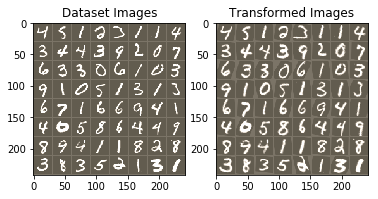

In [5]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()